**Problem statement:** To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### Take necessary actions to read the data

### Importing all the important libraries

In [152]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import matplotlib.pyplot as plt

from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, Rescaling

import warnings
warnings.filterwarnings('ignore')

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [153]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train")
data_dir_test = pathlib.Path("Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Test")

In [154]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [155]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [156]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split= 0.2,
    subset= 'training',
    image_size=(img_height,img_width),
    batch_size = batch_size
)


Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [157]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [158]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### create a code to visualize one instance of all the nine classes present in the dataset

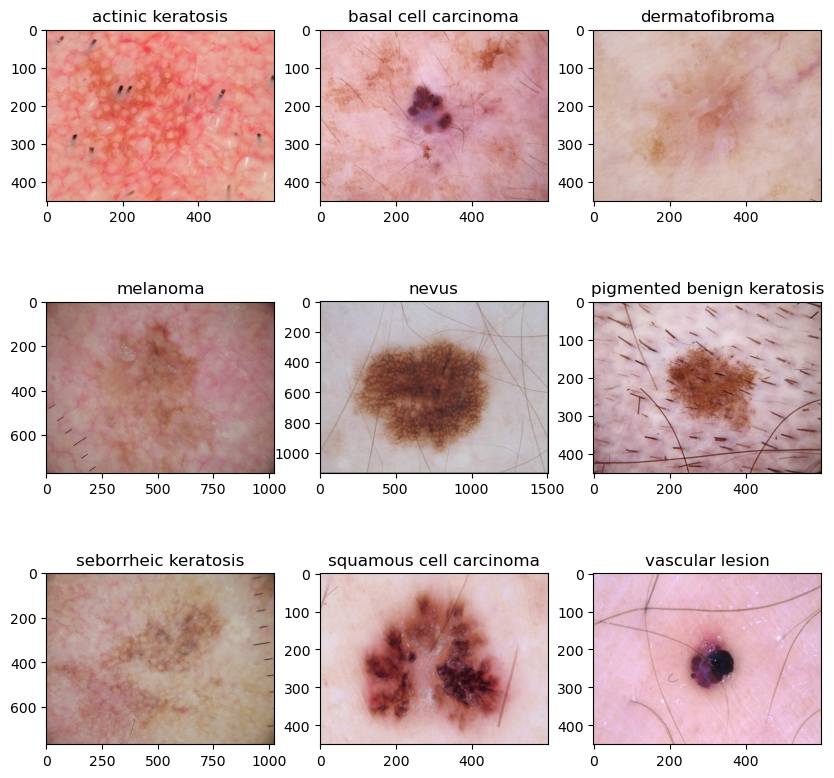

In [159]:
### your code goes here, you can use training or validation data to visualize

plt.figure(figsize=(10,10))
for i in range(9): 
  plt.subplot(3, 3, i + 1)
  image = plt.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [160]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [161]:
num_classes = 9
model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dropout(0.25),
    layers.Dense(512, activation='relu'),
    layers.Dense(len(class_names), activation='softmax')
])

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [162]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [163]:
# View the summary of all layers
model.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_9 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_36 (MaxPooling2D) │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_37 (MaxPooling2D) │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_38 (MaxPooling2D) │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 18, 18, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_39 (MaxPooling2D) │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 10368)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 10368)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 512)            │     5,308,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 9)              │         4,617 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,554,377 (21.19 MB)

 Trainable params: 5,554,377 (21.19 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [164]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 15s 230ms/step - accuracy: 0.1943 - loss: 2.1502 - val_accuracy: 0.2707 - val_loss: 1.9327
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 220ms/step - accuracy: 0.2857 - loss: 1.9149 - val_accuracy: 0.3065 - val_loss: 1.8353
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 217ms/step - accuracy: 0.3747 - loss: 1.7547 - val_accuracy: 0.3915 - val_loss: 1.6059
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 216ms/step - accuracy: 0.3924 - loss: 1.6649 - val_accuracy: 0.3803 - val_loss: 1.7436
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 219ms/step - accuracy: 0.4472 - loss: 1.5255 - val_accuracy: 0.4609 - val_loss: 1.5715
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 13s 224ms/step - accuracy: 0.4644 - loss: 1.5211 - val_accuracy: 0.5011 - val_loss: 1.4367
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 218ms/step - accuracy: 0.4995 - loss: 1.4433 - val_accuracy: 0.5056 - val_loss: 1.3977
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 216ms/step - accuracy: 0.5020 - loss: 1.3450 - val_accu

### Visualizing training results

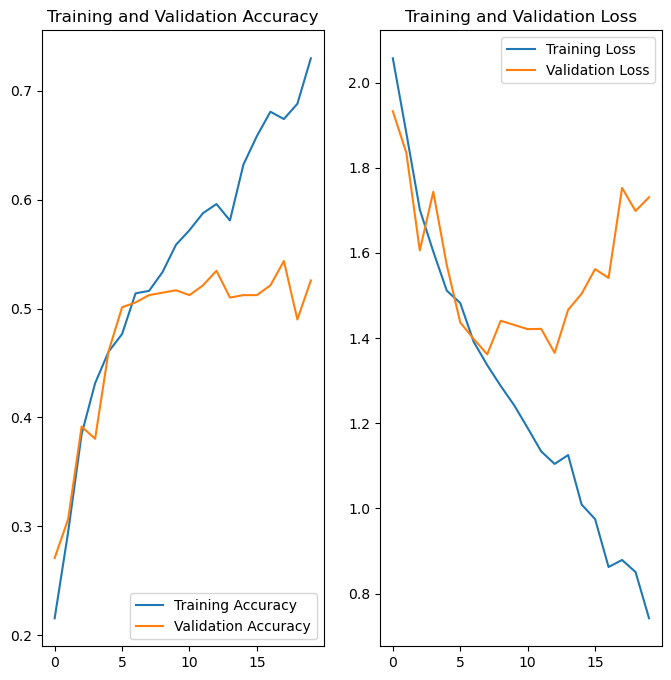

In [165]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Observation

The model appears to be overfitting. This is indicated by the significant difference between training and validation accuracy, as well as the validation loss increasing after an initial decrease.

In [166]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
data_augument = keras.Sequential([
    layers.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)),
    layers.RandomRotation(0.2, fill_mode='reflect'),
    layers.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect')
])

train_ds1 = train_ds.map(lambda x, y: (data_augument(x, training=True), y))
val_ds1 = val_ds.map(lambda x, y: (data_augument(x, training=True), y))

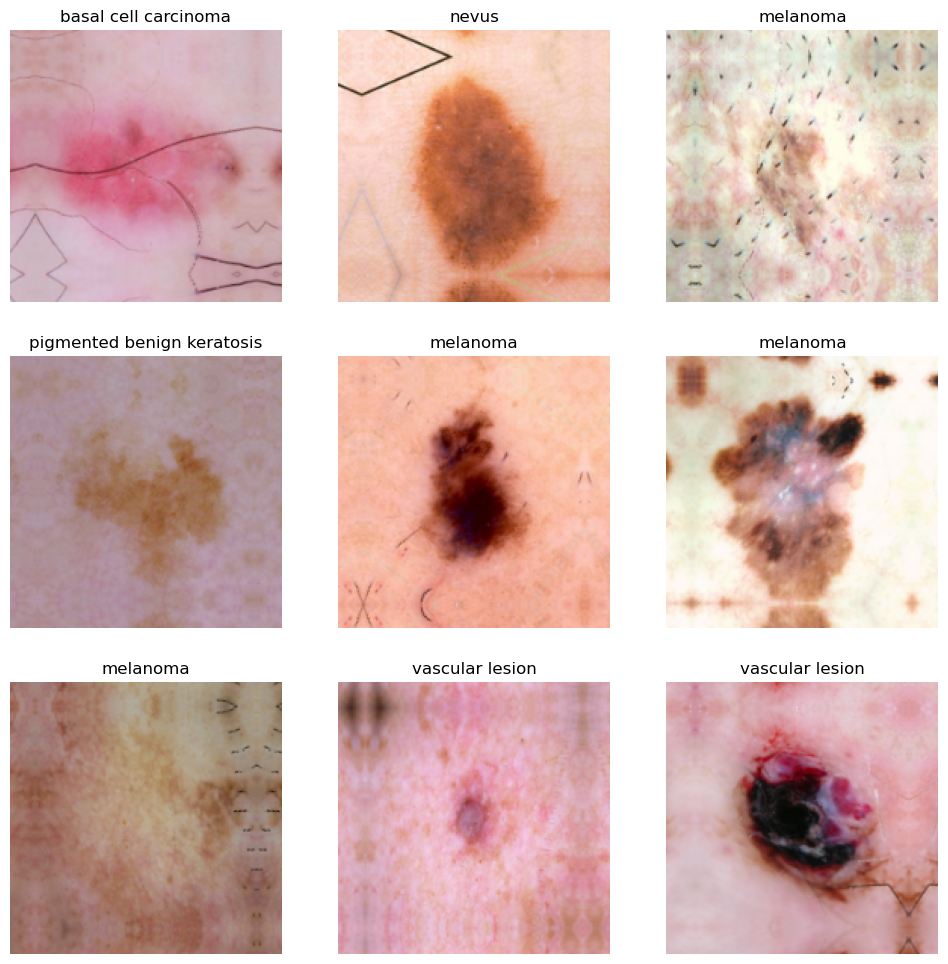

In [167]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(data_augument(images)[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### Create the model, compile and train the model

In [168]:
## You can use Dropout layer if there is an evidence of overfitting in your findings
num_classes = 9
model_aug = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu'),
    layers.Dense(len(class_names), activation='softmax')
])


### Compiling the model

In [169]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [170]:
## Your code goes here, note: train your model for 20 epochs
epochs=20
history = model.fit(
  train_ds1,
  validation_data=val_ds1,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 13s 229ms/step - accuracy: 0.4993 - loss: 1.4351 - val_accuracy: 0.5235 - val_loss: 1.3012
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 13s 228ms/step - accuracy: 0.5433 - loss: 1.2512 - val_accuracy: 0.5638 - val_loss: 1.2743
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 13s 234ms/step - accuracy: 0.5560 - loss: 1.1978 - val_accuracy: 0.5369 - val_loss: 1.2671
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 13s 234ms/step - accuracy: 0.5790 - loss: 1.1564 - val_accuracy: 0.5503 - val_loss: 1.2815
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 13s 232ms/step - accuracy: 0.6014 - loss: 1.0955 - val_accuracy: 0.5459 - val_loss: 1.3100
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 13s 228ms/step - accuracy: 0.5774 - loss: 1.1296 - val_accuracy: 0.5705 - val_loss: 1.2104
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 13s 228ms/step - accuracy: 0.6058 - loss: 1.1053 - val_accuracy: 0.5078 - val_loss: 1.4344
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 13s 229ms/step - accuracy: 0.5843 - loss: 1.1487 - val_accu

### Visualizing the results

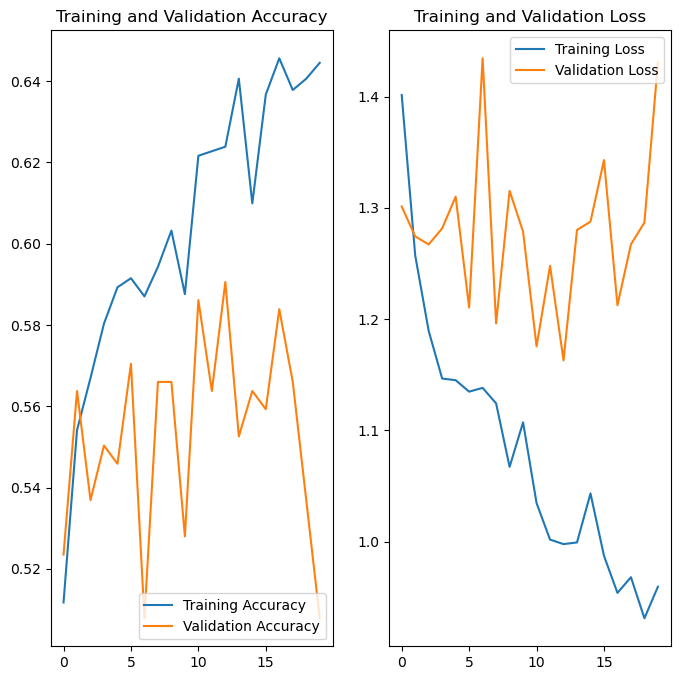

In [171]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

####  Observation

There is no improvement in accuracy but we can definitely see the overfitting problem has solved due to data augmentation

We can increase the epochs to increase the accuracy so it's too early for judgement

#### Find the distribution of classes in the training dataset.
**Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

path_list=[]
lesion_list=[]
for i in class_names:
      
    for j in data_dir_train.glob(i+'/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

In [172]:
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,Skin_cancer_ISIC_The_International_Skin_Imagin...,actinic keratosis
1,Skin_cancer_ISIC_The_International_Skin_Imagin...,actinic keratosis
2,Skin_cancer_ISIC_The_International_Skin_Imagin...,actinic keratosis
3,Skin_cancer_ISIC_The_International_Skin_Imagin...,actinic keratosis
4,Skin_cancer_ISIC_The_International_Skin_Imagin...,actinic keratosis
...,...,...
4495,Skin_cancer_ISIC_The_International_Skin_Imagin...,vascular lesion
4496,Skin_cancer_ISIC_The_International_Skin_Imagin...,vascular lesion
4497,Skin_cancer_ISIC_The_International_Skin_Imagin...,vascular lesion
4498,Skin_cancer_ISIC_The_International_Skin_Imagin...,vascular lesion


<BarContainer object of 9 artists>

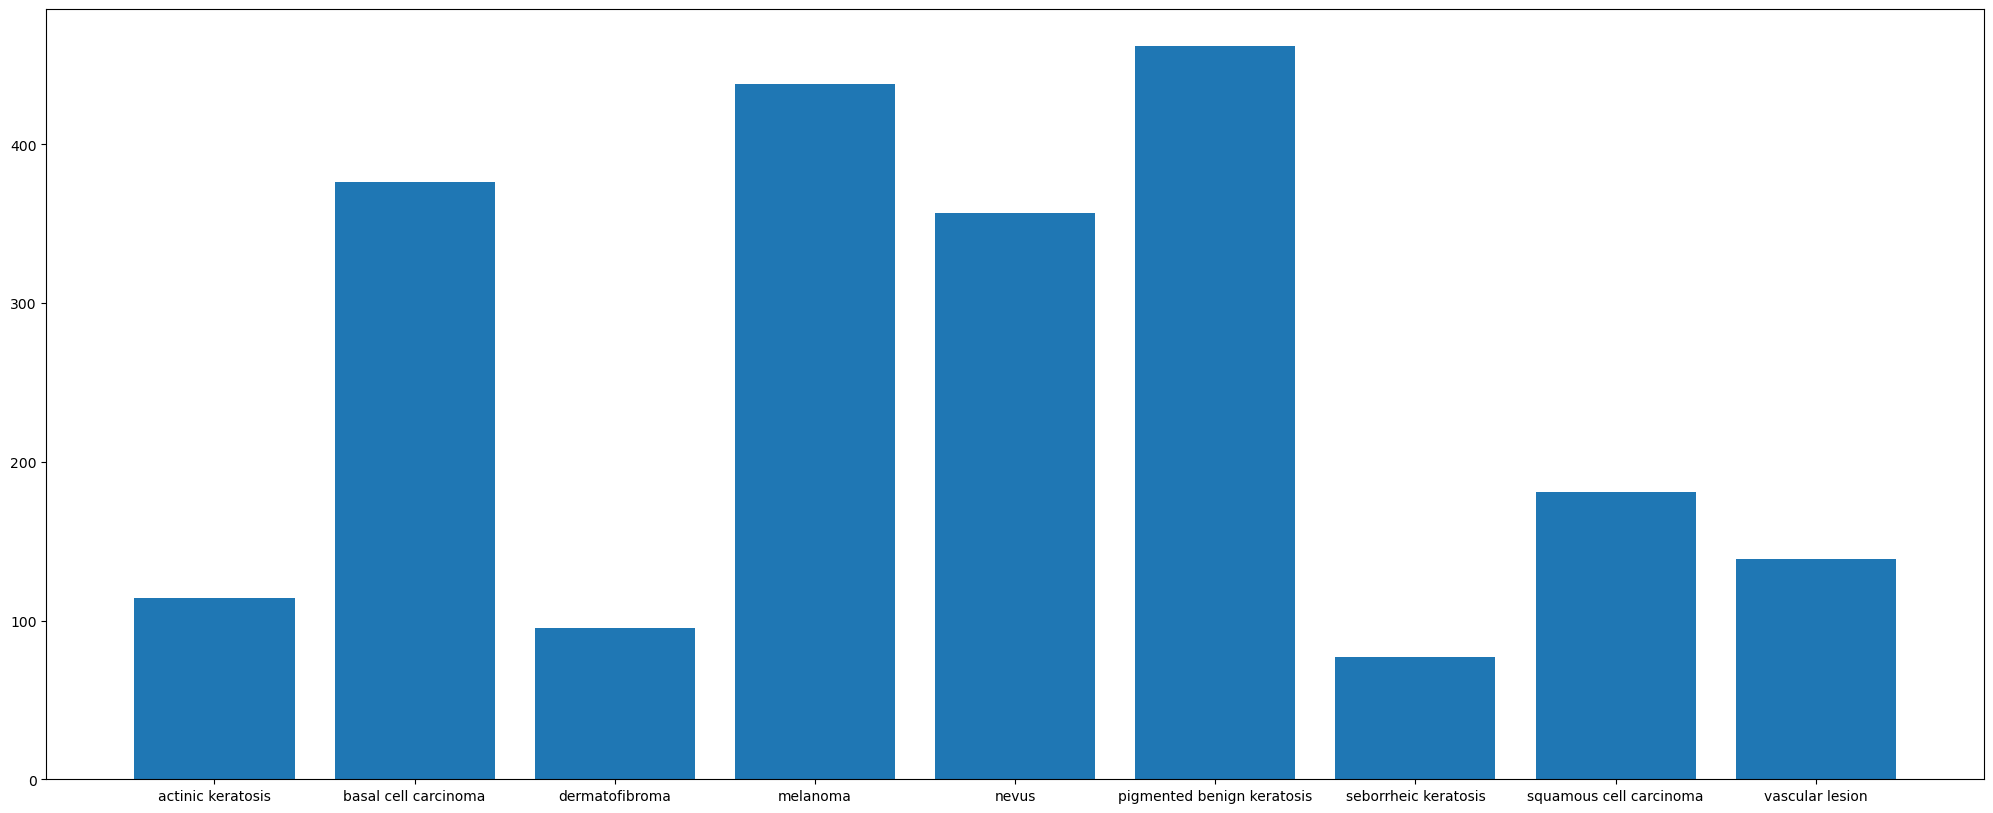

In [173]:
count=[]
for i in class_names:
    count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(25,10))
plt.bar(class_names,count)

### Observation
#### - Which class has the least number of samples?

Class with the least number of samples: Seborrheic keratosis

#### - Which classes dominate the data in terms proportionate number of samples?

Classes that dominate the data in terms of the proportionate number of samples: pigmented benign keratosis and melanoma

In [174]:
class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

### Rectify the class imbalance
**Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [175]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [176]:
import Augmentor

path_to_training_dataset="Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train"

for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset, save_format='jpg')
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.zoom_random(probability=0.5, percentage_area=0.8)
    p.flip_left_right(probability=0.5)
    p.flip_top_bottom(probability=0.5)
    p.random_contrast(probability=0.5, min_factor=0.7, max_factor=1.3)
    p.random_brightness(probability=0.5, min_factor=0.7, max_factor=1.3)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.
    
# New augmented dataset directory
augmented_data_dir = pathlib.Path(os.path.join(path_to_training_dataset, 'output'))

Initialised with 2239 image(s) found.
Output directory set to Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x167F6A3D0>: 100%|█|


Initialised with 2239 image(s) found.
Output directory set to Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x16781AB50>: 100%|█


Initialised with 2239 image(s) found.
Output directory set to Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x17B14FC10>: 100%|█|


Initialised with 2239 image(s) found.
Output directory set to Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x165B97950>: 100%|


Initialised with 2239 image(s) found.
Output directory set to Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/output.

Processing <PIL.Image.Image image mode=RGB size=2048x1536 at 0x17FE54850>: 100%|


Initialised with 2239 image(s) found.
Output directory set to Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x1679B6010>: 100%|█


Initialised with 2239 image(s) found.
Output directory set to Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x17FF7E210>: 100%|█|


Initialised with 2239 image(s) found.
Output directory set to Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x167F7E6D0>: 100%|█|


Initialised with 2239 image(s) found.
Output directory set to Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x164749A50>: 100%|█|


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [177]:
data_dir_train = pathlib.Path("Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/output")
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [178]:
path_list = []
lesion_list = []

for class_name in class_names:
    for img_path in augmented_data_dir.glob(class_name + '/*.jpg'):
        path_list.append(str(img_path))
        lesion_list.append(class_name)

dataframe_dict_original = dict(zip(path_list, lesion_list))
new_df = pd.DataFrame(list(dataframe_dict_original.items()), columns=['Path', 'Label'])

In [179]:
new_df['Label'].value_counts()

Label
melanoma                      910
pigmented benign keratosis    904
basal cell carcinoma          778
nevus                         724
squamous cell carcinoma       357
vascular lesion               276
actinic keratosis             209
dermatofibroma                189
seborrheic keratosis          153
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Train the model on the data created using Augmentor

In [180]:
batch_size = 32
img_height = 180
img_width = 180

####  Create a training dataset

In [181]:
data_dir_train1 = pathlib.Path("Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train")

train_ds2 = tf.keras.preprocessing.image_dataset_from_directory(
    augmented_data_dir,
    seed=123,
    validation_split=0.2,
    subset='training',
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 4500 files belonging to 9 classes.
Using 3600 files for training.


#### Create a validation dataset

In [182]:
val_ds2 = tf.keras.preprocessing.image_dataset_from_directory(
    augmented_data_dir,
    seed=123,
    validation_split=0.2,
    subset='validation',
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 4500 files belonging to 9 classes.
Using 900 files for validation.


#### Create your model (make sure to include normalization)

In [183]:
## You can use Dropout layer if there is an evidence of overfitting in your findings
num_classes = 9

model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dropout(0.25),
    layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.Dropout(0.25),
    layers.Dense(num_classes, activation='softmax')
])

#### Compile your model (Choose optimizer and loss function appropriately)

In [184]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

####  Train your model

In [185]:
epochs = 30
history = model.fit(
  train_ds2,
  validation_data=val_ds2,
  epochs=epochs
)

Epoch 1/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 42s 360ms/step - accuracy: 0.3084 - loss: 6.5844 - val_accuracy: 0.1533 - val_loss: 4.0684
Epoch 2/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 40s 354ms/step - accuracy: 0.4138 - loss: 3.4236 - val_accuracy: 0.2111 - val_loss: 4.0552
Epoch 3/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 40s 353ms/step - accuracy: 0.4759 - loss: 2.7818 - val_accuracy: 0.1211 - val_loss: 4.8882
Epoch 4/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 40s 353ms/step - accuracy: 0.5020 - loss: 2.5783 - val_accuracy: 0.2333 - val_loss: 3.4708
Epoch 5/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 40s 351ms/step - accuracy: 0.5440 - loss: 2.3911 - val_accuracy: 0.3578 - val_loss: 2.7776
Epoch 6/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 40s 354ms/step - accuracy: 0.5705 - loss: 2.2361 - val_accuracy: 0.3111 - val_loss: 4.1945
Epoch 7/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 40s 355ms/step - accuracy: 0.5896 - loss: 2.1111 - val_accuracy: 0.5078 - val_loss: 2.3503
Epoch 8/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 43s 381ms/step - accuracy: 0.6120 - loss: 1

####  Visualize the model results

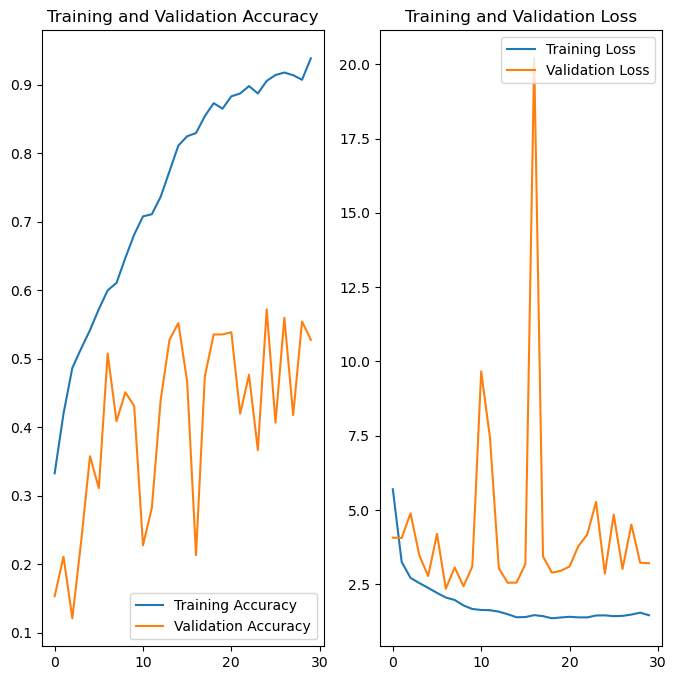

In [186]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Conclusion

- Model is still overfitting
- The problem of overfitting can be solved by add more layer, neurons or adding dropout layers.
- The Model can be further improved by tuning the hyperparameter.